# Raport zespołowy 2 - taxi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

# Ustawienie stylu wykresów
plt.style.use("default")
sns.set_palette("husl")

## Wczytania i podstawowa analiza danych

In [2]:
df = pd.read_csv(
    "taxi_trip_pricing.csv",
    sep=";",
    decimal=",",
    # Treat empty strings and spaces as NaN
    na_values=["", " ", "None"],
)

print(f"Liczba obserwacji: {df.shape[0]}")
print(f"Liczba czynników: {df.shape[1]}")

Liczba obserwacji: 1000
Liczba czynników: 11


In [3]:
print("Pierwsze 5 wierszy:", df.head(), sep="\n")

Pierwsze 5 wierszy:
   Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
0             19.35     Morning     Weekday              3.0   
1             47.59   Afternoon     Weekday              1.0   
2             36.87     Evening     Weekend              1.0   
3             30.33     Evening     Weekday              4.0   
4               NaN     Evening     Weekday              3.0   

  Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
0                Low   Clear       3.56         0.80             0.32   
1               High   Clear        NaN         0.62             0.43   
2               High   Clear       2.70         1.21             0.15   
3                Low     NaN       3.48         0.51             0.15   
4               High   Clear       2.93         0.63             0.32   

   Trip_Duration_Minutes  Trip_Price  
0                  53.82       36.26  
1                  40.57         NaN  
2                  37.27       52.90  


In [4]:

print("Informacje o danych:", df.info(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB
Informacje o danych:
None


In [5]:
print("Statystyki opisowe:", df.describe(), sep='\n')

Statystyki opisowe:
       Trip_Distance_km  Passenger_Count   Base_Fare  Per_Km_Rate  \
count        950.000000       950.000000  950.000000   950.000000   
mean          27.070568         2.476842    3.502989     1.233316   
std           19.905404         1.102249    0.870162     0.429816   
min            1.230000         1.000000    2.010000     0.500000   
25%           12.632500         1.250000    2.730000     0.860000   
50%           25.830000         2.000000    3.520000     1.220000   
75%           38.405000         3.000000    4.260000     1.610000   
max          146.070000         4.000000    5.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  
count       950.000000             950.000000  951.000000  
mean          0.292916              62.118116   56.874879  
std           0.115592              32.154406   40.469812  
min           0.100000               5.010000    6.130000  
25%           0.190000              35.882500   33.745000 

### Analiza jakości danych i czyszczenie

In [6]:
print("Brakujące wartości w każdej kolumnie:")
print(df.isnull().sum())

Brakujące wartości w każdej kolumnie:
Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64


#### Uzupełnienie brakujących wartości

Dla zmiennych numerycznych - oblicz mediane

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Uzupełniono {col} medianą: {median_val:.2f}")

Uzupełniono Trip_Distance_km medianą: 25.83
Uzupełniono Passenger_Count medianą: 2.00
Uzupełniono Base_Fare medianą: 3.52
Uzupełniono Per_Km_Rate medianą: 1.22
Uzupełniono Per_Minute_Rate medianą: 0.29
Uzupełniono Trip_Duration_Minutes medianą: 61.86
Uzupełniono Trip_Price medianą: 50.07


Zmienne kategoryczne - najczęstsza wartość

In [8]:
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
        df[col].fillna(mode_val, inplace=True)
        print(f"Uzupełniono {col}: {mode_val}")

Uzupełniono Time_of_Day: Afternoon
Uzupełniono Day_of_Week: Weekday
Uzupełniono Traffic_Conditions: Low
Uzupełniono Weather: Clear


## Eksploracyjna analiza danych

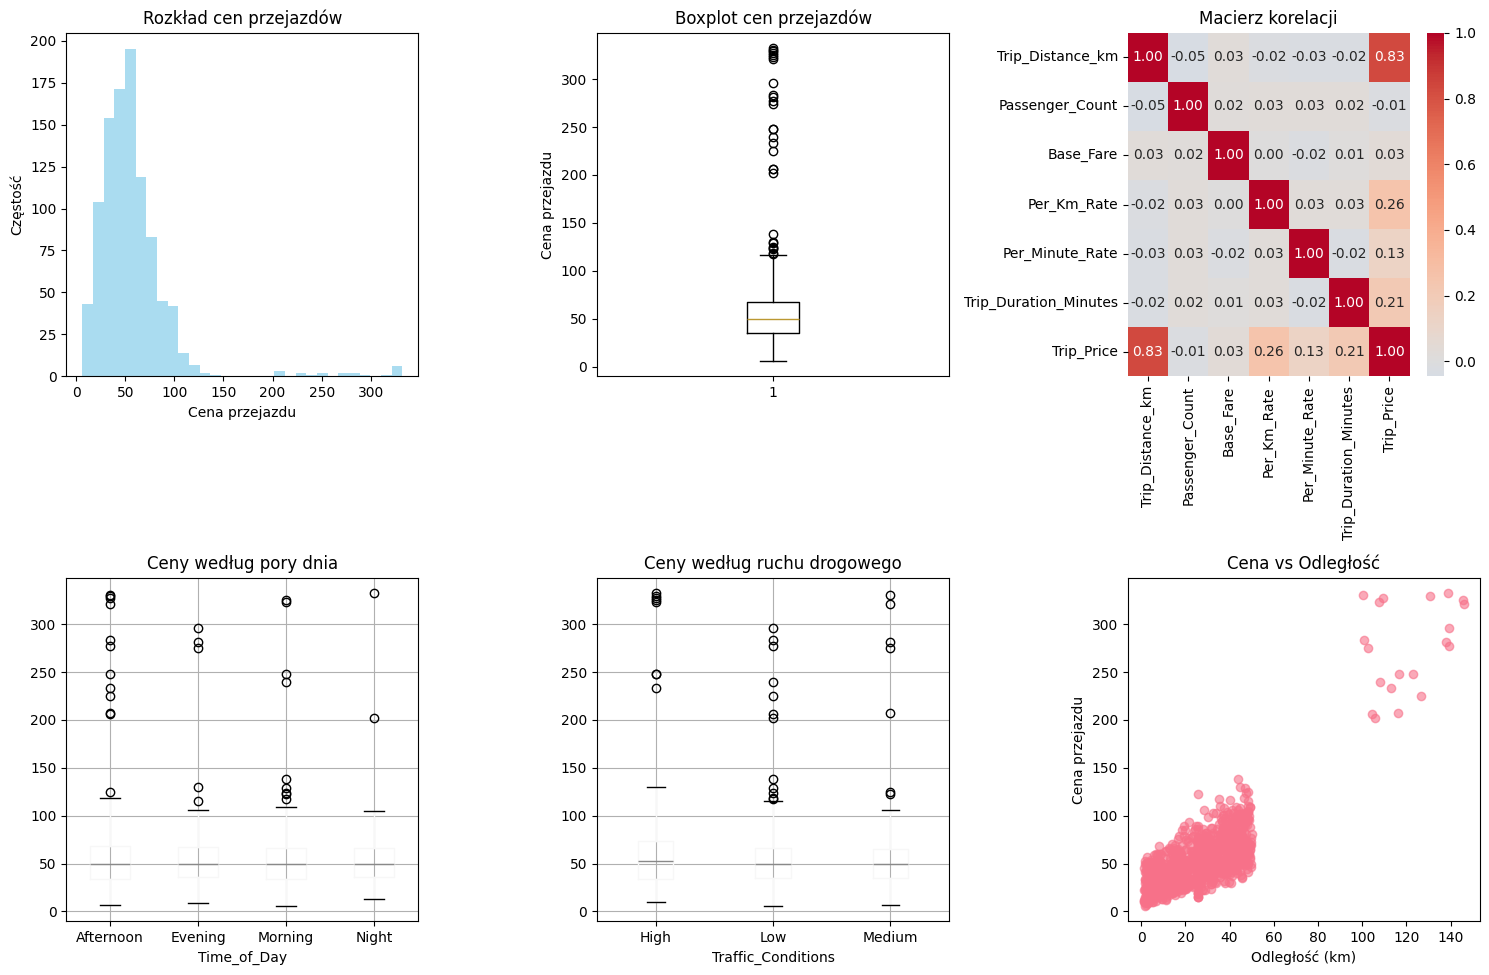

In [9]:
# Analiza zmiennej docelowej
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Trip_Price'], bins=30, alpha=0.7, color='skyblue')
plt.title('Rozkład cen przejazdów')
plt.xlabel('Cena przejazdu')
plt.ylabel('Częstość')

plt.subplot(2, 3, 2)
plt.boxplot(df['Trip_Price'])
plt.title('Boxplot cen przejazdów')
plt.ylabel('Cena przejazdu')

# Korelacje zmiennych numerycznych
plt.subplot(2, 3, 3)
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Macierz korelacji')

# Analiza według pory dnia
plt.subplot(2, 3, 4)
df.boxplot(column='Trip_Price', by='Time_of_Day', ax=plt.gca())
plt.title('Ceny według pory dnia')
plt.suptitle('')

# Analiza według warunków drogowych
plt.subplot(2, 3, 5)
df.boxplot(column='Trip_Price', by='Traffic_Conditions', ax=plt.gca())
plt.title('Ceny według ruchu drogowego')
plt.suptitle('')

# Zależność cena vs odległość
plt.subplot(2, 3, 6)
plt.scatter(df['Trip_Distance_km'], df['Trip_Price'], alpha=0.6)
plt.xlabel('Odległość (km)')
plt.ylabel('Cena przejazdu')
plt.title('Cena vs Odległość')

plt.tight_layout()
plt.savefig('exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Szczegółowa analiza korelacji z ceną

In [10]:
price_correlations = correlation_matrix['Trip_Price'].sort_values(key=abs, ascending=False)
print(price_correlations)

Trip_Price               1.000000
Trip_Distance_km         0.830482
Per_Km_Rate              0.256118
Trip_Duration_Minutes    0.214669
Per_Minute_Rate          0.131533
Base_Fare                0.033101
Passenger_Count         -0.012468
Name: Trip_Price, dtype: float64


Analiza zmiennych kategorycznych

In [11]:
categorical_vars = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
for var in categorical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        print(df.groupby(var)['Trip_Price'].agg(['mean', 'median', 'std']).round(2))



Time_of_Day:
              mean  median    std
Time_of_Day                      
Afternoon    57.46   50.07  42.68
Evening      56.22   49.79  36.96
Morning      55.58   50.07  36.59
Night        56.04   50.07  38.86

Day_of_Week:
              mean  median    std
Day_of_Week                      
Weekday      57.27   50.07  41.29
Weekend      54.80   49.51  34.83

Traffic_Conditions:
                     mean  median    std
Traffic_Conditions                      
High                64.24   53.08  56.20
Low                 55.22   50.07  34.45
Medium              54.35   50.07  34.63

Weather:
          mean  median    std
Weather                      
Clear    55.58   50.07  37.93
Rain     59.30   50.24  45.18
Snow     57.68   50.07  34.16


### Przygotowanie danych do modelowania

In [12]:
indices = [313142, 318046]  
seed = int(np.floor(np.mean(indices)))
print(f"Numery indeksów: {indices}")
print(f"Średnia: {np.mean(indices)}")
print(f"Ziarno (zaokrąglone w dół): {seed}")
np.random.seed(seed)

Numery indeksów: [313142, 318046]
Średnia: 315594.0
Ziarno (zaokrąglone w dół): 315594


Wybór predyktorów na podstawie analizy

In [13]:
# Usunięcie zmiennych o bardzo wysokiej korelacji (mogą powodować problem multikolinearności)
selected_features = ['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count', 
                    'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate', 
                    'Per_Minute_Rate', 'Trip_Duration_Minutes']

print("Wybrane predyktory:")
for feature in selected_features:
    print(f"- {feature}")

Wybrane predyktory:
- Trip_Distance_km
- Time_of_Day
- Day_of_Week
- Passenger_Count
- Traffic_Conditions
- Weather
- Base_Fare
- Per_Km_Rate
- Per_Minute_Rate
- Trip_Duration_Minutes


Przygotowanie danych

In [14]:
X = df[selected_features].copy()
y = df['Trip_Price'].copy()

# Kodowanie zmiennych kategorycznych
le_dict = {}
categorical_features = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

for feature in categorical_features:
    if feature in X.columns:
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature].astype(str))
        le_dict[feature] = le
        print(f"Zakodowano {feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Zakodowano Time_of_Day: {'Afternoon': np.int64(0), 'Evening': np.int64(1), 'Morning': np.int64(2), 'Night': np.int64(3)}
Zakodowano Day_of_Week: {'Weekday': np.int64(0), 'Weekend': np.int64(1)}
Zakodowano Traffic_Conditions: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}
Zakodowano Weather: {'Clear': np.int64(0), 'Rain': np.int64(1), 'Snow': np.int64(2)}


### Podział na zbiory uczący i testowy

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"Zbiór uczący: {X_train.shape[0]} próbek")
print(f"Zbiór testowy: {X_test.shape[0]} próbek")

Zbiór uczący: 800 próbek
Zbiór testowy: 200 próbek


## Budowa Modeli

Funkcja do obliczania metryk

In [16]:
def calculate_metrics(y_true, y_pred, dataset_name, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name} - {dataset_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    
    return rmse, mae, mape

### Model 1: Regresja Liniowa

Standaryzacja danych dla regresji liniowej

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Trenowanie modelu

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

Predykcje

In [19]:
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

Metryki

In [20]:

lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, "Zbiór uczący", "Regresja Liniowa")
lr_test_metrics = calculate_metrics(y_test, y_test_pred_lr, "Zbiór testowy", "Regresja Liniowa")

Regresja Liniowa - Zbiór uczący:
  RMSE: 16.2332
  MAE:  10.2849
  MAPE: 24.3966%
Regresja Liniowa - Zbiór testowy:
  RMSE: 15.0273
  MAE:  10.4078
  MAPE: 28.8183%


Ważność cech

In [21]:
feature_importance_lr = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nNajważniejsze cechy (Regresja Liniowa):")
print(feature_importance_lr.head(5))


Najważniejsze cechy (Regresja Liniowa):
                 feature  coefficient  abs_coefficient
0       Trip_Distance_km    33.829350        33.829350
7            Per_Km_Rate    10.143369        10.143369
9  Trip_Duration_Minutes     9.392426         9.392426
8        Per_Minute_Rate     6.053378         6.053378
1            Time_of_Day    -0.754130         0.754130


### Model 2: Random Forest

In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Wyszukiwanie najlepszych hiperparametrów...")
rf = RandomForestRegressor(random_state=seed)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Najlepsze parametry: {grid_search.best_params_}")

Wyszukiwanie najlepszych hiperparametrów...
Najlepsze parametry: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [23]:
best_rf = grid_search.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

Metryki

In [24]:
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, "Zbiór uczący", "Random Forest")
rf_test_metrics = calculate_metrics(y_test, y_test_pred_rf, "Zbiór testowy", "Random Forest")

Random Forest - Zbiór uczący:
  RMSE: 3.9514
  MAE:  2.5025
  MAPE: 5.3603%
Random Forest - Zbiór testowy:
  RMSE: 11.8831
  MAE:  6.8937
  MAPE: 14.9982%


Ważność cech

In [25]:
feature_importance_rf = pd.DataFrame({
    'feature': selected_features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nNajważniejsze cechy (Random Forest):")
print(feature_importance_rf.head(5))


Najważniejsze cechy (Random Forest):
                 feature  importance
0       Trip_Distance_km    0.787750
7            Per_Km_Rate    0.083651
9  Trip_Duration_Minutes    0.073564
8        Per_Minute_Rate    0.035728
6              Base_Fare    0.008846


### Porównanie modeli i wizualizacja

In [26]:
# Tabela porównawcza
comparison = pd.DataFrame({
    'Model': ['Regresja Liniowa', 'Random Forest'],
    'RMSE_train': [lr_train_metrics[0], rf_train_metrics[0]],
    'MAE_train': [lr_train_metrics[1], rf_train_metrics[1]],
    'MAPE_train': [lr_train_metrics[2], rf_train_metrics[2]],
    'RMSE_test': [lr_test_metrics[0], rf_test_metrics[0]],
    'MAE_test': [lr_test_metrics[1], rf_test_metrics[1]],
    'MAPE_test': [lr_test_metrics[2], rf_test_metrics[2]]
})

print("Porównanie modeli:")
print(comparison.round(4))

Porównanie modeli:
              Model  RMSE_train  MAE_train  MAPE_train  RMSE_test  MAE_test  \
0  Regresja Liniowa     16.2332    10.2849     24.3966    15.0273   10.4078   
1     Random Forest      3.9514     2.5025      5.3603    11.8831    6.8937   

   MAPE_test  
0    28.8183  
1    14.9982  


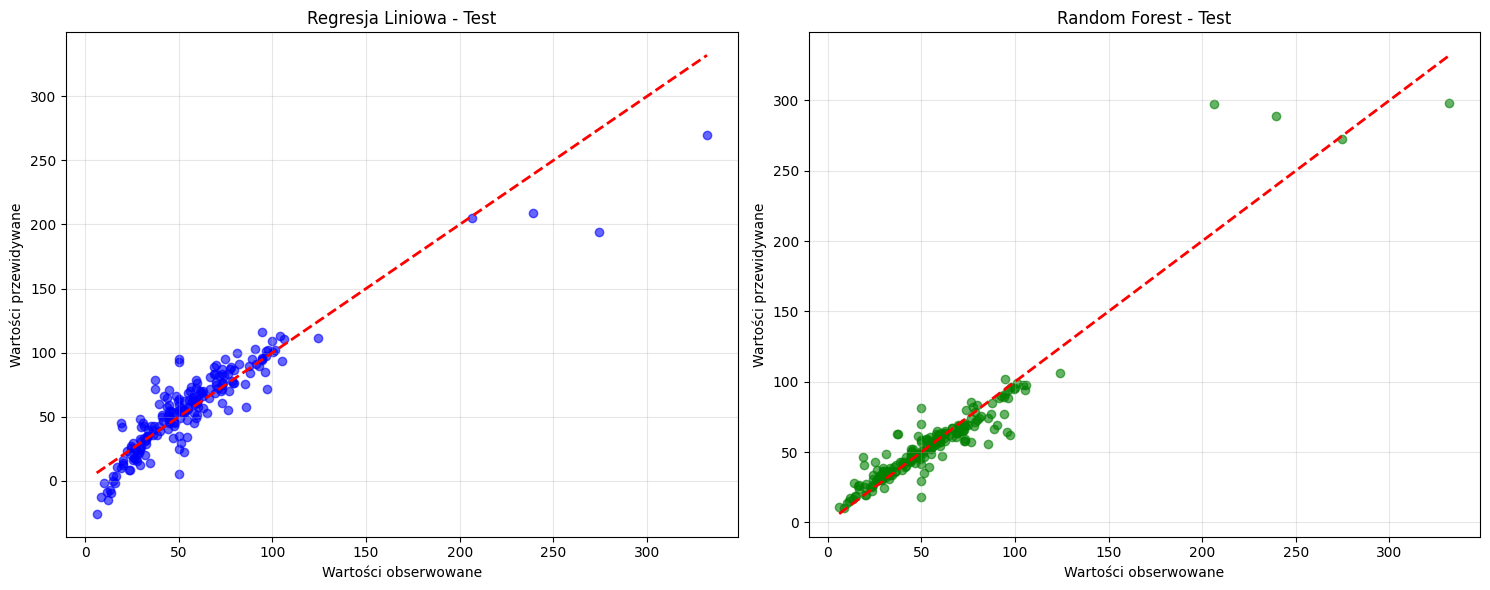

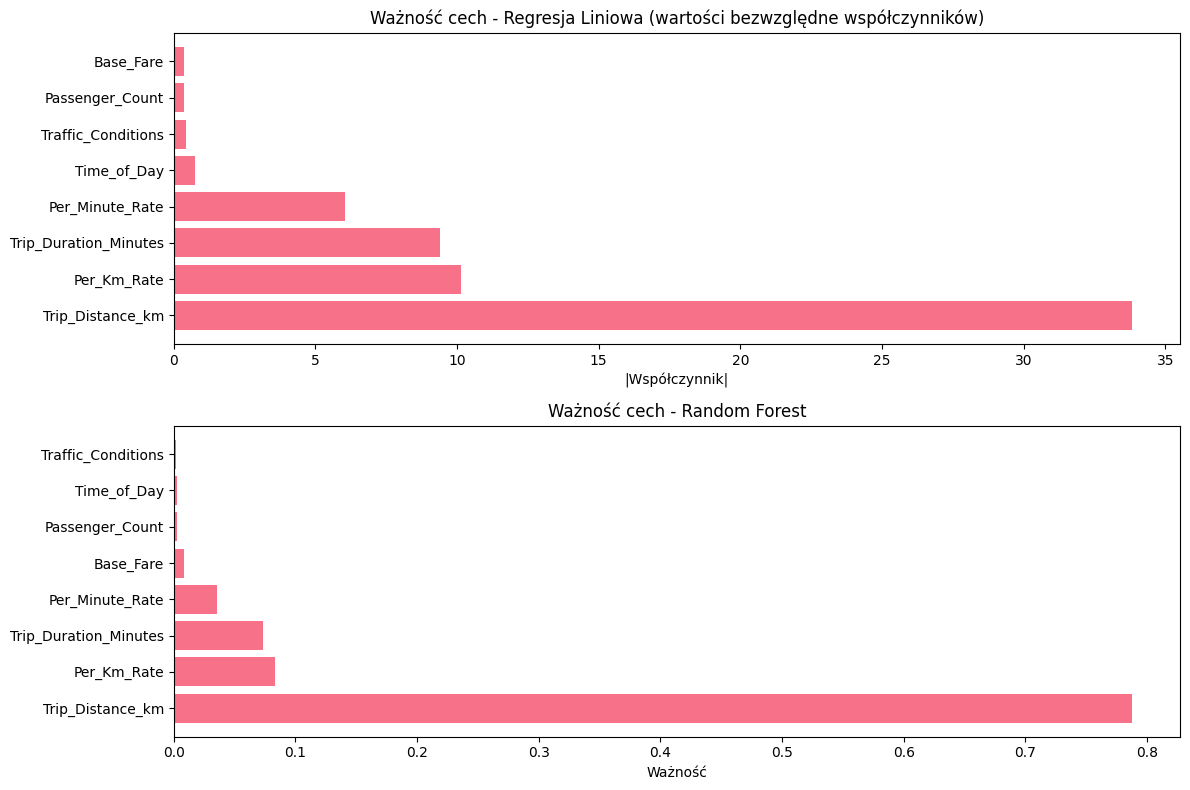

In [27]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Wartości obserwowane')
plt.ylabel('Wartości przewidywane')
plt.title('Regresja Liniowa - Test')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Wartości obserwowane')
plt.ylabel('Wartości przewidywane')
plt.title('Random Forest - Test')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Wykres ważności cech
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.barh(feature_importance_lr['feature'][:8], feature_importance_lr['abs_coefficient'][:8])
plt.title('Ważność cech - Regresja Liniowa (wartości bezwzględne współczynników)')
plt.xlabel('|Współczynnik|')

plt.subplot(2, 1, 2)
plt.barh(feature_importance_rf['feature'][:8], feature_importance_rf['importance'][:8])
plt.title('Ważność cech - Random Forest')
plt.xlabel('Ważność')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Analiza reszt

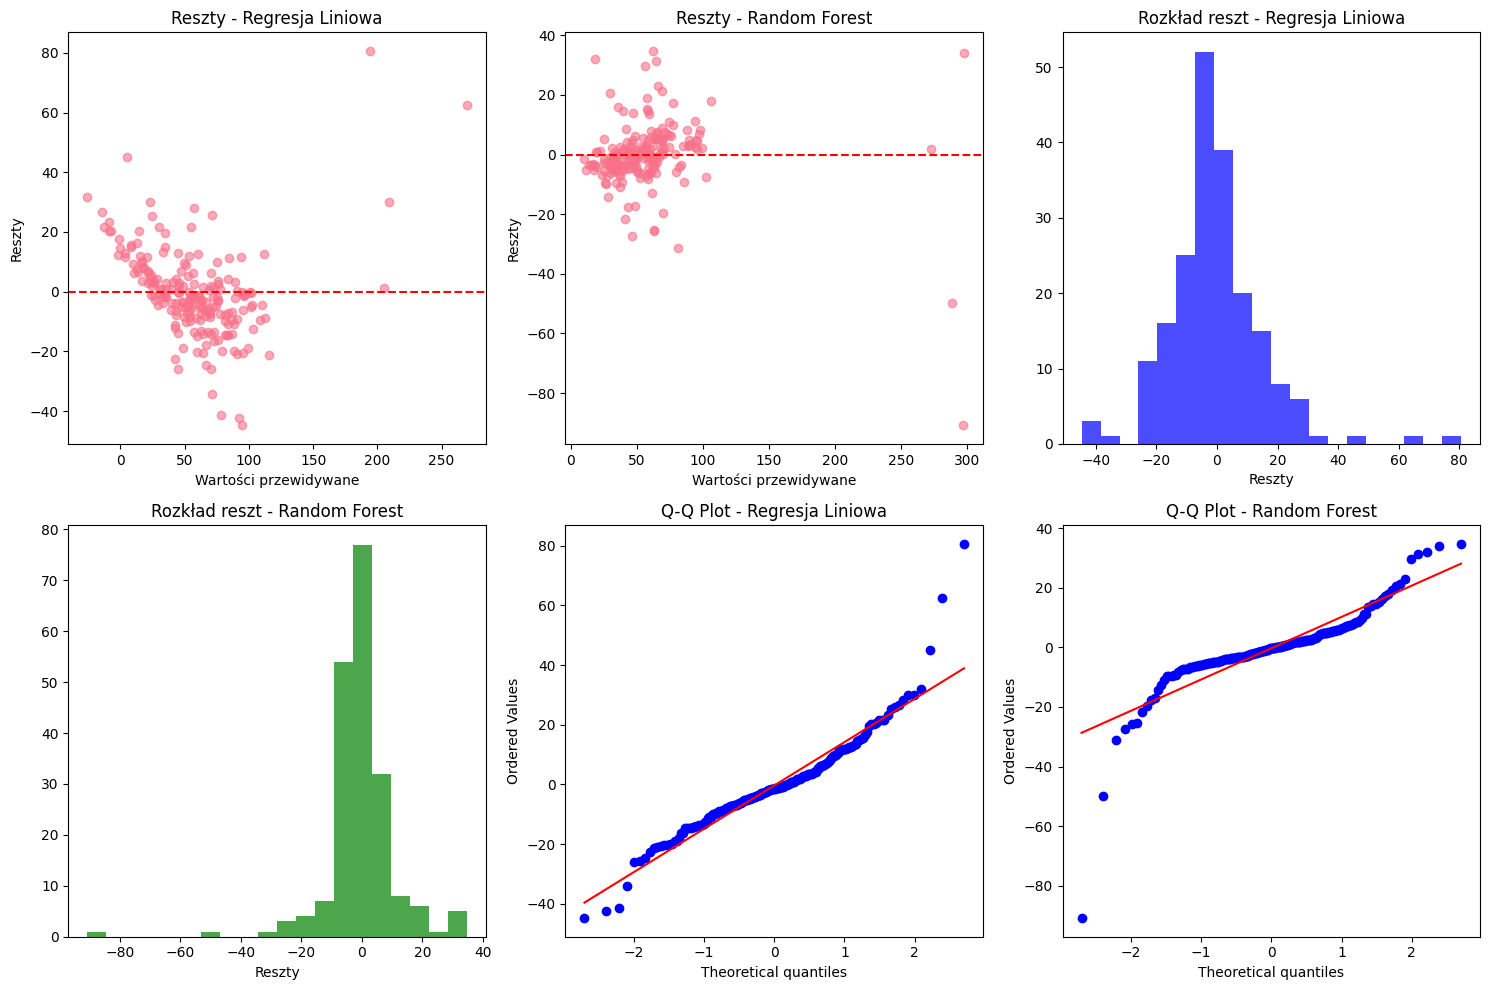


Statystyki reszt - Regresja Liniowa:
Średnia reszt: -0.3398
Mediana reszt: -1.5044
Odchylenie standardowe reszt: 15.0235
Min reszt: -44.7225
Max reszt: 80.5974

Statystyki reszt - Random Forest:
Średnia reszt: -0.3101
Mediana reszt: -0.3032
Odchylenie standardowe reszt: 11.8790
Min reszt: -90.7938
Max reszt: 34.7230


In [28]:
# Q-Q plot dla normalności reszt
from scipy import stats

# Reszty dla obu modeli
residuals_lr = y_test - y_test_pred_lr
residuals_rf = y_test - y_test_pred_rf

plt.figure(figsize=(15, 10))

# Wykres reszt vs przewidywane
plt.subplot(2, 3, 1)
plt.scatter(y_test_pred_lr, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Reszty - Regresja Liniowa')

plt.subplot(2, 3, 2)
plt.scatter(y_test_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Reszty - Random Forest')

# Histogram reszt
plt.subplot(2, 3, 3)
plt.hist(residuals_lr, bins=20, alpha=0.7, color='blue')
plt.title('Rozkład reszt - Regresja Liniowa')
plt.xlabel('Reszty')

plt.subplot(2, 3, 4)
plt.hist(residuals_rf, bins=20, alpha=0.7, color='green')
plt.title('Rozkład reszt - Random Forest')
plt.xlabel('Reszty')


plt.subplot(2, 3, 5)
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title('Q-Q Plot - Regresja Liniowa')

plt.subplot(2, 3, 6)
stats.probplot(residuals_rf, dist="norm", plot=plt)
plt.title('Q-Q Plot - Random Forest')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStatystyki reszt - Regresja Liniowa:")
print(f"Średnia reszt: {np.mean(residuals_lr):.4f}")
print(f"Mediana reszt: {np.median(residuals_lr):.4f}")
print(f"Odchylenie standardowe reszt: {np.std(residuals_lr):.4f}")
print(f"Min reszt: {np.min(residuals_lr):.4f}")
print(f"Max reszt: {np.max(residuals_lr):.4f}")

print("\nStatystyki reszt - Random Forest:")
print(f"Średnia reszt: {np.mean(residuals_rf):.4f}")
print(f"Mediana reszt: {np.median(residuals_rf):.4f}")
print(f"Odchylenie standardowe reszt: {np.std(residuals_rf):.4f}")
print(f"Min reszt: {np.min(residuals_rf):.4f}")
print(f"Max reszt: {np.max(residuals_rf):.4f}")

## Wnioski i rekomendacje

### Wnioski
- Najsilniejsze korelacje z ceną:
  - odległość
  - czas trwania
  - stawki

#### Porównanie Modeli

In [29]:
if rf_test_metrics[0] < lr_test_metrics[0]:  # Porównanie RMSE
    print("   - Random Forest osiągnął lepsze wyniki niż Regresja Liniowa")
    better_model = "Random Forest"
else:
    print("   - Regresja Liniowa osiągnęła lepsze wyniki niż Random Forest")
    better_model = "Regresja Liniowa"

print(f"   - Rekomendowany model: {better_model}")

   - Random Forest osiągnął lepsze wyniki niż Regresja Liniowa
   - Rekomendowany model: Random Forest


#### Najważniejsze predyktory

In [30]:
print("   Random Forest:", ", ".join(feature_importance_rf.head(3)['feature'].tolist()))
print("   Regresja Liniowa:", ", ".join(feature_importance_lr.head(3)['feature'].tolist()))

   Random Forest: Trip_Distance_km, Per_Km_Rate, Trip_Duration_Minutes
   Regresja Liniowa: Trip_Distance_km, Per_Km_Rate, Trip_Duration_Minutes


#### Analiza Przeuczenia

In [31]:
train_test_diff_lr = abs(lr_train_metrics[0] - lr_test_metrics[0])
train_test_diff_rf = abs(rf_train_metrics[0] - rf_test_metrics[0])

print(f"   - Różnica RMSE (train-test) Regresja Liniowa: {train_test_diff_lr:.4f}")
print(f"   - Różnica RMSE (train-test) Random Forest: {train_test_diff_rf:.4f}")

if train_test_diff_rf > train_test_diff_lr * 2:
    print("   - Random Forest może być przeuczony")
elif train_test_diff_lr > train_test_diff_rf * 2:
    print("   - Regresja Liniowa może być przeuczana")
else:
    print("   - Oba modele wydają się być odpowiednio dopasowane")

   - Różnica RMSE (train-test) Regresja Liniowa: 1.2058
   - Różnica RMSE (train-test) Random Forest: 7.9316
   - Random Forest może być przeuczony


In [32]:

print("ANALIZA ZAKOŃCZONA")
print("Zapisano wykresy: exploratory_analysis.png, model_predictions.png,")
print("feature_importance.png, residual_analysis.png")

ANALIZA ZAKOŃCZONA
Zapisano wykresy: exploratory_analysis.png, model_predictions.png,
feature_importance.png, residual_analysis.png
